In [20]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets


In [21]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.6.0+cu124  Device: cpu


In [22]:
DEVICE

device(type='cpu')

In [23]:
BATCH_SIZE = 32
EPOCHS = 10

In [24]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())


test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [25]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break


X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


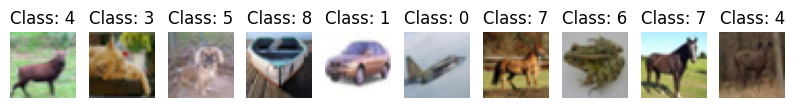

In [26]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))


for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)


    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [28]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [29]:
pip install torchinfo

In [30]:
from torchinfo import summary

In [31]:
summary(model, inpit_size=(32*32*3))

Layer (type:depth-idx)                   Param #
Net                                      --
├─Linear: 1-1                            1,573,376
├─Linear: 1-2                            131,328
├─Linear: 1-3                            2,570
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0

In [32]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()


        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))


In [33]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0


    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [34]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.309337


KeyboardInterrupt: 

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


In [43]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()


In [44]:
summary(model, input_size=(3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Conv2d: 1-1                            [8, 32, 32]               224
├─MaxPool2d: 1-2                         [8, 16, 16]               --
├─Conv2d: 1-3                            [16, 16, 16]              1,168
├─MaxPool2d: 1-4                         [16, 8, 8]                --
├─Linear: 1-5                            [1, 64]                   65,600
├─Linear: 1-6                            [1, 32]                   2,080
├─Linear: 1-7                            [1, 10]                   330
Total params: 69,402
Trainable params: 69,402
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.42
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.28
Estimated Total Size (MB): 0.39

In [38]:
3*3*3*8+8

224

In [39]:
3*3*8*16+16

1168

In [40]:
16*8*8*62+64

63552

In [45]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.279738
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.048342
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.847453
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.665632
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.623038
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.501498
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.649513
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.605336

[EPOCH: 1], 	Test Loss: 1.4554, 	Test Accuracy: 46.49 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.157428
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.512511
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.489072
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.157877
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.573626
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.220039
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.165544
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.254206

[EPOCH: 2], 	Test Loss: 1.3278, 	Test Accuracy: 51.82 % 